In [29]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM, GRU, TimeDistributed
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D, MaxPool1D
from keras.backend import expand_dims, squeeze
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd
import random
import import_ipynb
import Sample_making

In [30]:
df_target = pd.read_csv('../../Target_words_dataframe')
df_unknown = pd.read_csv('../../Unknown_words_dataframe')
df = pd.read_csv('../../full_df')

In [31]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [32]:
filename = 'Data_spotter_mfcc_40'
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [33]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [34]:
def save_model_history(model_history, model_history_name):
    filename = 'saved_models_history/' + model_history_name
    outfile = open(filename,'wb')
    pickle.dump(model_history, outfile)
    outfile.close()

In [35]:
def report(model, X, y, classes):
    model_predictions = model.predict(X).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return sklearn.metrics.classification_report(true_predictions, model_predictions, target_names=classes)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=42)

In [37]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58248, 40, 61)
Y_train size = (58248,)
X_test size = (6473, 40, 61)
Y_test size = (6473,)


In [38]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [39]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [40]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [41]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')

X_train size = (58248, 40, 61, 1)
X_test size = (6473, 40, 61, 1)


In [42]:
def DNN_model(input_shape, nclass):
    
    input_ = Input(input_shape)
    
    X = Dense(64, activation="relu")(input_)
    X = Dense(128, activation="relu")(X)
    
    X = Flatten()(X)
    
    X = expand_dims(X, axis=-1)
    X = MaxPool1D(pool_size=2, strides=2, data_format='channels_last')(X)
    X = squeeze(X, axis=-1)
    
    X = Dropout(rate=0.1)(X)
    X = Dense(128, activation="linear")(X)
    X = Dense(256, activation="relu")(X)
    
    output_ = Dense(nclass, activation='softmax')(X)
    
    ret_model = Model(inputs = input_, outputs=output_)
    
    return ret_model

In [43]:
model = DNN_model((40, 61, 1), len(lb.classes_))

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40, 61, 1)]       0         
_________________________________________________________________
dense_12 (Dense)             (None, 40, 61, 64)        128       
_________________________________________________________________
dense_13 (Dense)             (None, 40, 61, 128)       8320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 312320)            0         
_________________________________________________________________
tf.expand_dims_3 (TFOpLambda (None, 312320, 1)         0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 156160, 1)         0         
_________________________________________________________________
tf.compat.v1.squeeze_2 (TFOp (None, 156160)            0   

In [45]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ["accuracy"])

model_history = model.fit(x = X_train, y = Y_train, epochs = 6, batch_size = 16, validation_data=(X_test, Y_test))

Epoch 1/6
3641/3641 [==============================] - 810s 222ms/step - loss: 0.1768 - accuracy: 0.6693 - val_loss: 0.1143 - val_accuracy: 0.7684
Epoch 2/6
3641/3641 [==============================] - 792s 217ms/step - loss: 0.0982 - accuracy: 0.8019 - val_loss: 0.1013 - val_accuracy: 0.7901
Epoch 3/6
3641/3641 [==============================] - 792s 217ms/step - loss: 0.0680 - accuracy: 0.8694 - val_loss: 0.1131 - val_accuracy: 0.7944
Epoch 4/6
3641/3641 [==============================] - 789s 217ms/step - loss: 0.0446 - accuracy: 0.9212 - val_loss: 0.1112 - val_accuracy: 0.7972
Epoch 5/6
3641/3641 [==============================] - 790s 217ms/step - loss: 0.0293 - accuracy: 0.9522 - val_loss: 0.1315 - val_accuracy: 0.7961
Epoch 6/6
3641/3641 [==============================] - 791s 217ms/step - loss: 0.0212 - accuracy: 0.9693 - val_loss: 0.1699 - val_accuracy: 0.7908


In [46]:
save_model(model, "DNN")

INFO:tensorflow:Assets written to: C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\DNN\assets
Save model and weights at C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\DNN 


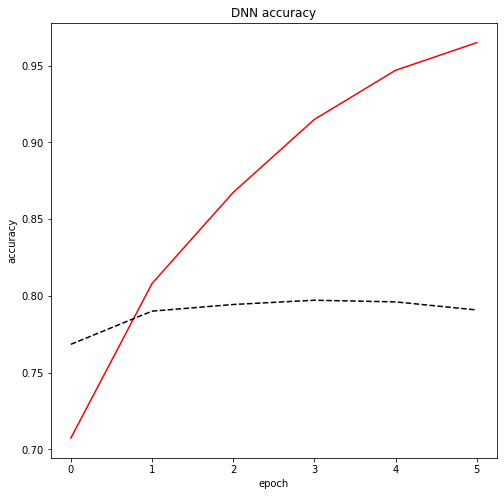

In [47]:
plt.figure(figsize=(8,8))
plt.plot(model_history.history['accuracy'], 
         color="red")
plt.plot(model_history.history['val_accuracy'], 
         color="black", 
         linestyle="dashed")
plt.title('DNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("DNN")
plt.show()

In [48]:
save_model_history(model_history.history, "DNN")

In [49]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.59      0.57      0.58       254
          go       0.52      0.53      0.52       229
        left       0.74      0.58      0.65       236
          no       0.66      0.43      0.52       242
         off       0.61      0.70      0.65       226
          on       0.64      0.57      0.60       229
       right       0.74      0.62      0.68       252
        stop       0.80      0.66      0.72       235
     unknown       0.85      0.90      0.87      4081
          up       0.65      0.55      0.60       250
         yes       0.90      0.78      0.84       239

    accuracy                           0.79      6473
   macro avg       0.70      0.63      0.66      6473
weighted avg       0.79      0.79      0.79      6473

